# Data Analysis Notebook

In this notebook, we will:
1. Preprocess the raw `animelist.csv` data to get `train`, `val`, and `test` sets.
2. Inspect basic statistics about the dataset:
   - Number of users and items.
   - Distribution of ratings.
   - Average number of anime per user.
   - Genre distributions from `anime.csv`.
3. Validate that our dataset construction and preprocessing appear correct.

This is an exploratory data analysis step to ensure that everything is as expected before training models.


In [1]:
# Executing this cell does some magic
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
src_path = '../src'
sys.path.append(src_path)

In [3]:
# Required imports
import pandas as pd
import torch
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
    
# Assuming these scripts are in src/ or current directory
from dataset.rating_dataset import preprocess_data, RatingDataset  # Adjust path as needed
from dataset.anime_data import AnimeData  # Adjust path as needed


## Step 1: Preprocess Data

We'll use the `preprocess_data` function to get `train`, `val`, and `test` sets with an 80/10/10 split.


In [4]:
train_dataset, val_dataset, test_dataset = preprocess_data(
    filepath='../data/raw/animelist.csv',
    user_range=10000,  # for example, limit to first 10k users
    include_watching_status=False,
    include_watched_episodes=False,
    zero_strategy='average',
    random_state=42,
    save_interaction_matrix=True
)

len_train = len(train_dataset)
len_val = len(val_dataset)
len_test = len(test_dataset)
print(f"Training samples: {len_train}, Validation samples: {len_val}, Test samples: {len_test}")


Training samples: 2600126, Validation samples: 325016, Test samples: 325016


Check if the splitting is correct: we expect approximately 80%, 10%, 10%.


In [5]:
total = len_train + len_val + len_test
print("Total samples:", total)
print("Train ratio:", len_train / total)
print("Val ratio:", len_val / total)
print("Test ratio:", len_test / total)


Total samples: 3250158
Train ratio: 0.79999987692906
Val ratio: 0.10000006153546996
Test ratio: 0.10000006153546996


## Step 2: Basic Statistics

We can convert the dataset objects back to DataFrames to analyze them more easily.


In [6]:
train_df = train_dataset.data
val_df = val_dataset.data
test_df = test_dataset.data
train_df.head()

,user_id,anime_id,rating,watching_status,watched_episodes
0,3608,242,7.000000,1,0
1,10202,12477,9.090909,6,0
2,4741,7724,7.000000,2,22
3,2279,33049,9.000000,2,1
4,3916,394,4.000000,2,12


### Number of unique users and items

We can check how many unique users and anime appear in the training set.


In [7]:
unique_users = train_df['user_id'].nunique()
unique_items = train_df['anime_id'].nunique()
print("Unique users in train:", unique_users)
print("Unique items in train:", unique_items)


Unique users in train: 9979
Unique items in train: 15926


### Average number of anime rated per user

Let's see how many ratings each user has on average in the training set.


Average number of anime rated per user (train): 260.5597755286101


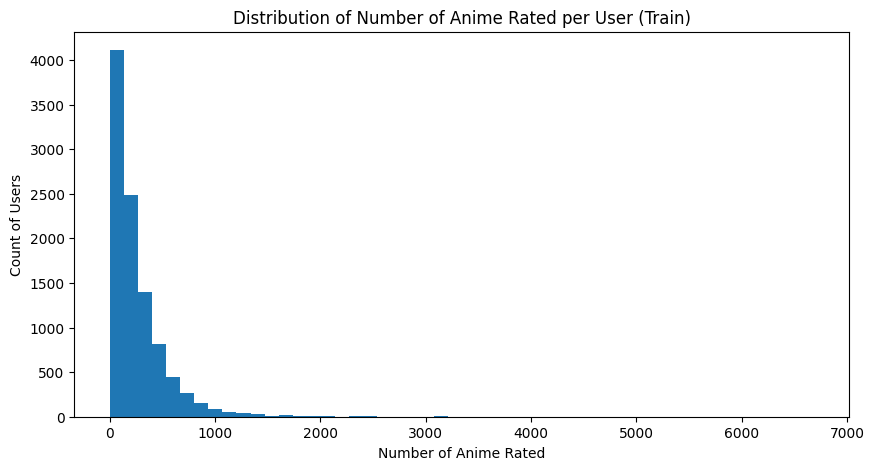

In [8]:
ratings_per_user = train_df.groupby('user_id')['anime_id'].count()
avg_ratings_per_user = ratings_per_user.mean()
print("Average number of anime rated per user (train):", avg_ratings_per_user)

# Distribution of ratings per user
plt.figure(figsize=(10,5))
plt.hist(ratings_per_user, bins=50)
plt.title("Distribution of Number of Anime Rated per User (Train)")
plt.xlabel("Number of Anime Rated")
plt.ylabel("Count of Users")
plt.show()


### Rating Distribution

Check the distribution of ratings given by users.


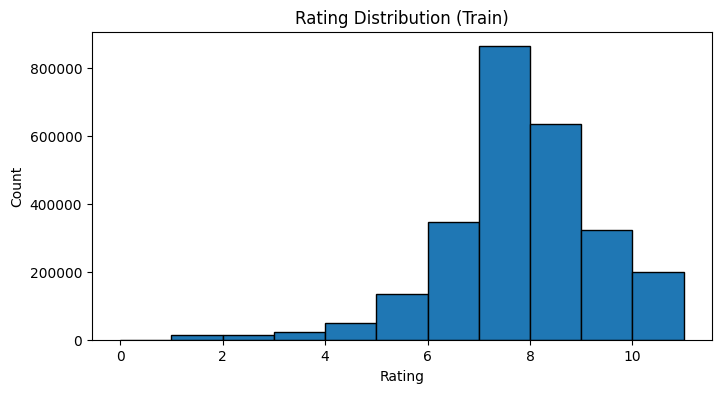

Mean rating (train): 7.536213079630885
Median rating (train): 7.68780487804878


In [9]:
plt.figure(figsize=(8,4))
plt.hist(train_df['rating'], bins=11, range=(0,11), edgecolor='black')
plt.title("Rating Distribution (Train)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

print("Mean rating (train):", train_df['rating'].mean())
print("Median rating (train):", train_df['rating'].median())


## Step 3: Inspect Anime Metadata

We have `anime.csv`. Let's load it via `AnimeData` to examine genres, types, etc.


In [10]:
anime_data = AnimeData(filepath='../data/raw/anime.csv')
print("Anime DataFrame shape:", anime_data.df.shape)
anime_data.df.head()


Anime DataFrame shape: (17562, 37)


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,StartDate,EndDate
0,1,Cowboy Bebop,8.78,"[Action, Adventure, Comedy, Drama, Sci-Fi, Space]",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,-8.718497,-7.660963
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"[Action, Drama, Mystery, Sci-Fi, Space]",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,-5.307310,-5.307310
2,6,Trigun,8.24,"[Action, Sci-Fi, Adventure, Comedy, Drama, Sho...",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,-8.723977,-8.227858
3,7,Witch Hunter Robin,7.27,"[Action, Mystery, Police, Supernatural, Drama,...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,-4.471237,-3.994296
4,8,Bouken Ou Beet,6.98,"[Adventure, Fantasy, Shounen, Supernatural]",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,-2.227858,-1.230598


### Genre Distribution

We can look at how frequently each genre appears.


Top 20 genres:
Comedy           6029
Action           3888
Fantasy          3285
Adventure        2957
Kids             2665
Drama            2619
Sci-Fi           2583
Music            2244
Shounen          2003
Slice of Life    1914
Romance          1899
School           1642
Supernatural     1479
Hentai           1348
Historical       1144
Mecha            1101
Magic            1081
Seinen            830
Ecchi             767
Mystery           727
Name: count, dtype: int64


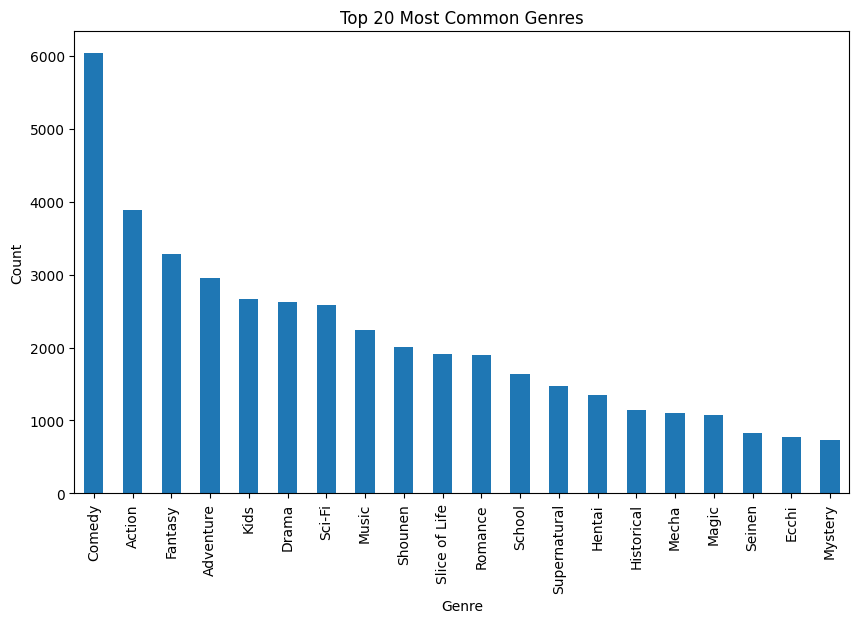

In [16]:
all_genres = anime_data.df['Genres'].dropna().tolist()
# Flatten list of lists
flat_genres = [g for genre_list in all_genres for g in genre_list]

genre_counts = pd.Series(flat_genres).value_counts()
print("Top 20 genres:")
print(genre_counts.head(20))

# Plot genre distribution
plt.figure(figsize=(10,6))
genre_counts.head(20).plot(kind='bar')
plt.title("Top 20 Most Common Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()


## Step 4: Cross-check Consistency

- Ensure that all user_ids and anime_ids in the train/val/test sets appear in the top `user_range` users and that anime_ids appear in `anime_data`.

We'll just do a quick sanity check for a few samples.


In [ ]:
sample_train = train_df.sample(5)
print("Sample from train dataset:")
print(sample_train)

for idx, row in sample_train.iterrows():
    mal_id = row['anime_id']
    # Check if anime exists in anime_data
    anime_row = anime_data.df[anime_data.df['MAL_ID'] == mal_id]
    if anime_row.empty:
        print(f"Warning: Anime {mal_id} not found in anime_data!")


Sample from train dataset:
         user_id  anime_id    rating  watching_status  watched_episodes
1889934     3326      1889  7.561538                6                 0
1116521     2507     33082  8.592683                6                 0
2107795     9587     31637  9.000000                2                12
1263730     6695     21939  7.000000                2                10
2072040    10591     30307  4.000000                2                12
